In [1]:

import time
import numpy as np
import math 
import cv2
import matplotlib.pyplot as plt
import opencv_jupyter_ui as jcv2

## Libraries 
from src.Motion_Control import thymio as th
from src.Global_Nav import helpers_global as gb
from src.Vision import vision as vs
#import filtering 
from src.Local_Nav import psymap as pm  
from src.Local_Nav import local_navigation as ln
from src.Filtering import filtering
import PID 



In [2]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node() #_ = protected #__ = private = shouldn't access node outside of the class
await node.lock()

Node 7648c768-a4cd-4427-9998-204136028638

In [3]:
## Constant 
MAP_SHAPE = (1000,700)
REFRAME = True 
TS =0.01
EPSILON_ANGLE= np.pi/4
VISUALIZE = True
MAP_SHAPE_MM = (1000,700)
MAP_SHAPE_CELL = (50,35)
ROBROAD = 110
SIMPLIFY = 0.8

In [7]:
await th.get_proximity_ground_values(client)

[1019, 1021]

In [4]:
#Load the camera : 25sec

cap = cv2.VideoCapture(0)


[[927.        ]
 [553.        ]
 [  4.49551536]
 [  0.        ]
 [  0.        ]]
Initial Map:
Map with optimal path


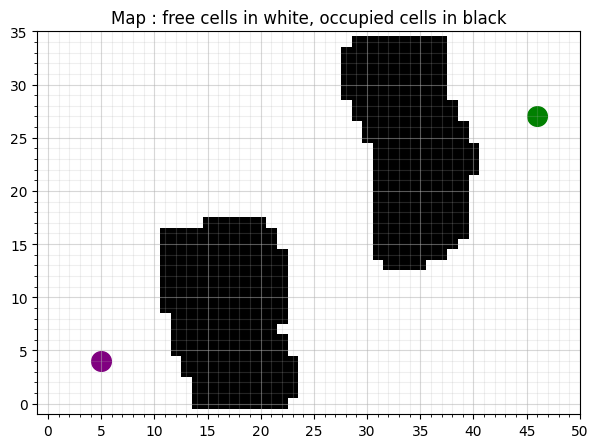

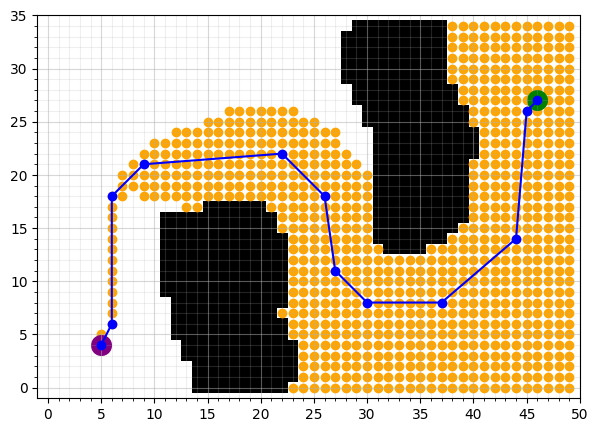

In [8]:
path, state_estimation_prev2, P_estimation_prev = th.init(cap, REFRAME, MAP_SHAPE, VISUALIZE,ROBROAD, SIMPLIFY )

Searching for destination...
Found destination Point at [460 608] [mm] (23, 5) [cells]
Searching for Robot...
Robot found at [956 569] [mm], 2.647651284670212 [rad]
Initial Map:
Map with optimal path


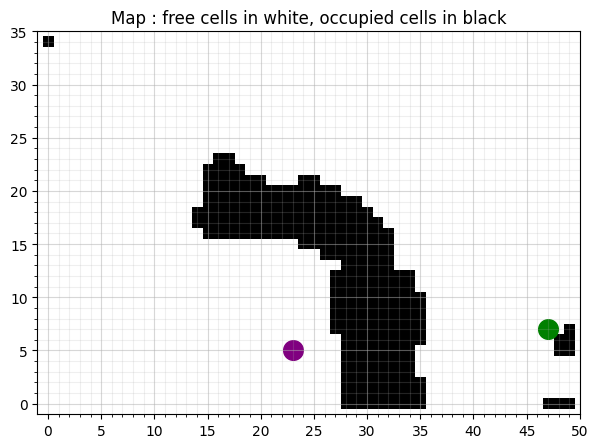

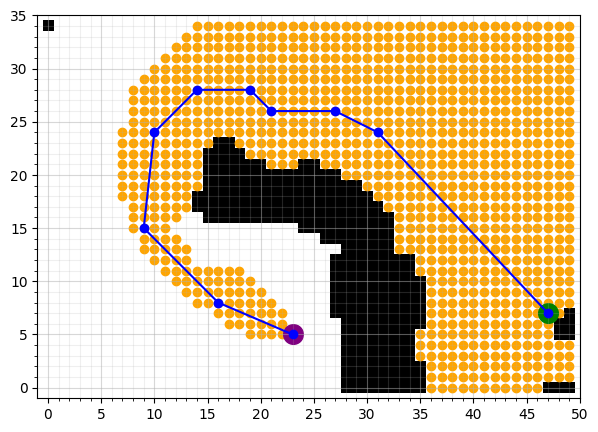

In [5]:
#setup
if REFRAME:
    Tmap = vs.get_warp(cap,MAP_SHAPE_MM,20,10)

ret,frame = cap.read()
if ret:
    if REFRAME:
        frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
    fmap = vs.get_grid_fixed_map(frame,MAP_SHAPE_CELL, robrad=50)
    obscont = vs.get_obstacles(frame)
    print("Searching for destination...")
    while True:
        ret,frame = cap.read()
        if ret:
            if REFRAME:
                frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
            ret,destmm = vs.get_destination(frame)
            if ret:
                dest = gb.convert_to_idx([coord / 10.0 for coord in destmm],2)
                dest[1]= 35-dest[1]
                dest = tuple(dest)
                break
            else:
                cv2.imshow()
        else:
            print("No camera !")
            break
    print("Found destination Point at {} [mm] {} [cells]".format(destmm,dest))
    print("Searching for Robot...")
    while True:
        ret,frame = cap.read()
        if ret:
            if REFRAME:
                frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE_MM)
            hls_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL) 
            ret,robpos,orient,pxpcm = vs.get_Robot_position_orientation(hls_frame)
            if ret:
                print("Robot found at {} [mm], {} [rad]".format(robpos,orient))
                break
        else:
            print("No camera !")
            break

start = gb.convert_to_idx(robpos,20)
start[1]= MAP_SHAPE_CELL[1]-start[1]
start = tuple(start)
path = gb.global_final(fmap,start,dest, "8N", VISUALIZE)

state_estimation_prev2 = np.array([[robpos[0]],[700-robpos[1]], [orient], [0], [0]])
P_estimation_prev =  np.diag([100, 100, 0.75, 10, 0.75])


In [ ]:
start = gb.convert_to_idx(robpos,20)
start[1]= MAP_SHAPE_CELL[1]-start[1]
start = tuple(start)
path = gb.global_final(fmap,start,dest, "8N", VISUALIZE)

state_estimation_prev2 = np.array([[robpos[0]],[700-robpos[1]], [orient], [0], [0]])
P_estimation_prev =  np.diag([100, 100, 0.75, 10, 0.75])

Le robot est en position de [48.17511722  6.25827022], converti en index [48, 6] et le prochain check point est [31 24]
Le robot est en position de [32.39257786 22.91503201], converti en index [32, 22] et le prochain check point est [27 26]
Le robot est en position de [28.48865767 26.83573623], converti en index [28, 26] et le prochain check point est [21 26]
Le robot est en position de [21.68853474 27.62656143], converti en index [21, 27] et le prochain check point est [19 28]
Le robot est en position de [20.74147497 27.18465542], converti en index [20, 27] et le prochain check point est [14 28]
Le robot est en position de [15.65845381 28.57701277], converti en index [15, 28] et le prochain check point est [10 24]
Le robot est en position de [10.14400005 25.64759243], converti en index [10, 25] et le prochain check point est [ 9 15]
Le robot est en position de [ 8.28836575 16.79478675], converti en index [8, 16] et le prochain check point est [16  8]
Le robot est en position de [14.24

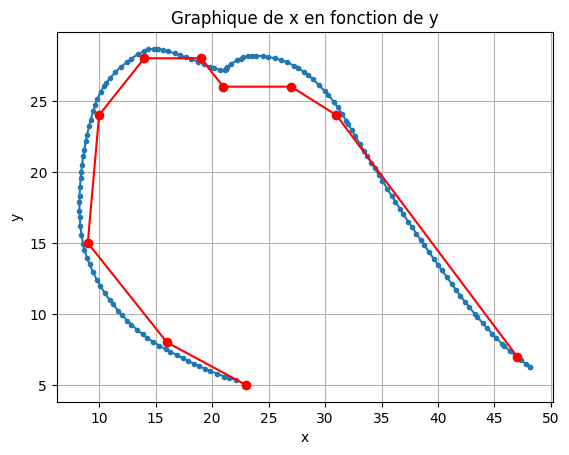

In [6]:
##Main boucle with Kalman Aubin

local_obstacle = False
counter=0
record= []

check=[]
check_point_prev=np.array([0,0])

start_time = time.time()
kidnapping_state = False

state_estimation_prev= state_estimation_prev2
Tmap = vs.get_warp(cap,MAP_SHAPE,10,1)
while True:
    
    

    ret,frame = cap.read()
    if ret : 
        ground_values = await th.get_proximity_ground_values(client)
        if(ground_values[0]<300 or ground_values[1]< 300):
            print('Kidnapping detected')
            await th.stop_motor(node)
            kidnapping_state= True


        if ground_values[0]>300 and ground_values[1]>300 and kidnapping_state:

            kidnapping_state = False
            while True :
                bool_pos ,center,orient, scale = vs.get_Robot_position_orientation(HLS, 5)
                if bool_pos : 
                #center = center/20.0
                    center[1] = 700- center[1]
                    start = gb.convert_to_idx(center,20)
                    start = tuple(start)
                    path = gb.global_final(fmap,start,dest, "8N", VISUALIZE)
                    state_estimation_prev2 = np.array([[center[0]],[center[1]], [orient], [0], [0]])
                    P_estimation_prev =  np.diag([100, 100, 0.75, 10, 0.75])
                    break

        # maps capture to map
        if REFRAME:
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE)
        # maps BGR to HLS color space for simplicity
        HLS = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)

        bool_pos ,center,orient, scale = vs.get_Robot_position_orientation(HLS, 5)
        if bool_pos : 
            #center = center/20.0
            center[1] = 700- center[1]
            orient2 = orient
            if orient <0:
                orient = orient +2*np.pi
            x_est_cam = np.array([center[0], center[1], orient])
            marre = np.array([x_est_cam[0]/20, x_est_cam[1]/20, orient2])
            record.append(marre)
            
        else :
            x_est_cam = None
     
        if not kidnapping_state:
            state_estimation, P_estimation, speed, angular_speed, start_time, angle = await filtering.get_position(state_estimation_prev, P_estimation_prev, start_time,bool_pos,x_est_cam, node )
            state_estimation_prev = state_estimation
            P_estimation_prev = P_estimation

            position = np.array([state_estimation[0].item(), state_estimation[1].item()])
            theta = angle
            position = position / 20.0
            position_array = np.array(position)
            
        
            
            check_point, counter = gb.next_checkpoint2(path, position, counter,local_obstacle)
        # if theta > np.pi :
            # theta = theta-2*np.pi
        # if theta < -np.pi:
            #  theta = theta+ 2*np.pi    
                
            marre2 = np.array([position_array[0], position_array[1], theta[0]])
            check.append(marre2)
            if np.any(check_point_prev != check_point):
                print(f"Le robot est en position de {position}, converti en index {gb.convert_to_idx(position, 1)} et le prochain check point est {check_point}")
                check_point_prev = check_point
                
            if abs(position[0]-path[-1][0])<1 and abs(position[1]-path[-1][1])<1:
                await th.stop_motor(node)
                break

            angle_error=  theta-th.compute_angle(gb.convert_to_idx(position,1), path[counter])
            if angle_error > np.pi :
                angle_error = angle_error-2*np.pi
            if angle_error < -np.pi:
                angle_error = angle_error+ 2*np.pi

        
            #local nav
            #sensor values
            obscont = vs.get_obstacles(frame, robrad = 10)
            capthall = pm.hallucinate_map([position[0],position[1],(-orient)],obscont)
            sens = await th.get_proximity_values(client)
            if (sum(sens[i] > 1000 for i in range(0, 5)) > 0):#before 2500
                local_obstacle = True

            if(local_obstacle):
                print("local nav on")
                await ln.local_navigation2(client,node,[position[0],position[1],(-orient)],obscont)
            
                if(not sum(sens[i] > 1000 for i in range(0, 5)) > 0):
                    await th.motorset(node,100,100)
                    time.sleep(2)
                    local_obstacle = False
            #motor control
            else :
                if(angle_error>EPSILON_ANGLE):
                    await th.motorset(node,70,-70)
                elif (angle_error<-EPSILON_ANGLE):
                    await th.motorset(node,-70,70)
                else:
                    speed_l, speed_r = PID.PIDController(50, angle_error)
                    await th.motorset(node,speed_l,speed_r)
                
    await client.sleep(TS)      
   
if VISUALIZE :
    x_values = [coord[0] for coord in check]
    y_values = [coord[1] for coord in check]
    x_path =   [coord[0] for coord in path]
    y_path =  [coord[1] for coord in path]

    # Tracer le graphique x en fonction de y
    plt.plot(x_values, y_values, marker='.', linestyle='-')
    plt.plot(x_path, y_path, marker ='o', color = 'red')
    plt.title('Graphique de x en fonction de y')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

           



    

In [7]:
await th.stop_motor(node)

In [7]:

## Main boucle with local nav without filtering 

local_obstacle = False
counter=0
record= []
angle =[]
check=[]
check_point_prev=np.array([0,0])
while True:
    ret,frame = cap.read()
    Tmap = vs.get_warp(cap,MAP_SHAPE,10,1)
    if ret:
        # maps capture to map
        if REFRAME:
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE)
        # maps BGR to HLS color space for simplicity
        HLS = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)
        obscont = vs.get_obstacles(frame, robrad = 10)
        bool_pos ,center,orient, scale = vs.get_Robot_position_orientation(HLS, 5)
        if bool_pos : 
            center = center/20.0
            center[1] = 35- center[1]
            
            x_est_cam = [center[0], center[1], orient]
            
            record.append(x_est_cam)
        #if VISUALIZE:
            #vizu = vs.visualizer(HLS)
            #omap =vs.grid_fixedmap_visualizer(fmap.transpose(),MAP_SHAPE_MM)
            #obsimg = cv2.merge([omap,omap,omap])
            #vizu = cv2.bitwise_or(vizu,obsimg)
            #vizu = vs.draw_obstacles_poly(vizu,obscont,(255,255,0),2)
            #vizu = cv2.circle(vizu,destmm,20,(50,25,100),4)
           # vizu = cv2.addWeighted(vizu,0.5,frame,0.5,0)
            #if bool_pos:
                #vizu = show_path(vizu,path,20,center)
                #vizu = vs.paint_robot(vizu,(0,0,200),center,orient,scale)
                #vizu = pm.hallucinate_map([center[0],center[1],(-orient)],obscont,vizu)
            
           # jcv2.imshow("Map",vizu)
           # if jcv2.waitKey(1) & 0xFF == ord('q'):
               # break
        if bool_pos : 
            check_point, counter = gb.next_checkpoint2(path, center, counter,local_obstacle)
            #print(counter)
            check.append(counter)
            if np.any(check_point_prev != check_point):
                print(f"Le robot est en position de {center}, converti en index {gb.convert_to_idx(center, 1)} et le prochain check point est {check_point}")
                check_point_prev = check_point
                
            if abs(center[0]-path[-1][0])<1 and abs(center[1]-path[-1][1])<1:
                await th.stop_motor(node)
                break

            angle_error=  orient-th.compute_angle(gb.convert_to_idx(center,1), path[counter])
            if angle_error > np.pi :
                angle_error = angle_error-2*np.pi
            if angle_error < -np.pi:
                angle_error = angle_error+ 2*np.pi

            #print(f"L'angle du robot est {orient} et l'angle vers le goal est {th.compute_angle(gb.convert_to_idx(center,1) , check_point)} et l'angle error est {angle_error}")
            angle.append(angle_error)
            #local nav
            #sensor values
            capthall = pm.hallucinate_map([center[0],center[1],(-orient)],obscont)
            sens = await th.get_proximity_values(client)
            if (sum(sens[i] > 500 for i in range(0, 5)) > 0):
                local_obstacle = True

            if(local_obstacle):
                print("local nav on")
                await ln.local_navigation(client,node,[center[0],center[1],(-orient)],obscont)
                
                if(not sum(sens[i] > 500 for i in range(0, 5)) > 0):
                    await th.motorset(node,100,100)
                    await client.sleep(1.5)
                    local_obstacle = False
                
            #motor control
            else :
                if(angle_error>EPSILON_ANGLE):
                    await th.motorset(node,70,-70)
                elif (angle_error<-EPSILON_ANGLE):
                    await th.motorset(node,-70,70)
                else:
                    await th.motorset(node,120,120)
            
    await client.sleep(TS)      


if VISUALIZE : 
    x_values = [coord[0] for coord in record]
    y_values = [coord[1] for coord in record]
    x_path =   [coord[0] for coord in path]
    y_path =  [coord[1] for coord in path]

    # Tracer le graphique x en fonction de y
    plt.plot(x_values, y_values, marker='.', linestyle='-')
    plt.plot(x_path, y_path, marker ='o', color = 'red')
    plt.title('Graphique de x en fonction de y')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

        

Le robot est en position de [40.7   3.85], converti en index [40, 3] et le prochain check point est [45  8]
local nav onalid samples
Le robot est en position de [43.4  5.9], converti en index [43, 5] et le prochain check point est [39 19]
local nav on
local nav onalid samples
local nav onalid samples


CancelledError: 

In [ ]:
await th.stop_motor(node)

In [ ]:
path, state_estimation_prev2, P_estimation_prev = th.init(cap, REFRAME, MAP_SHAPE, VISUALIZE)


In [ ]:
## MAIN boucle with kalman aubin debug 

t = 0
local_obstacle = False
counter=0
record= []
angle =[]
check=[]
check_point_prev=np.array([0,0])

start_time = time.time()

norm_distance=[]
state_estimation_prev= state_estimation_prev2

while True:
    #node = await client.wait_for_node()
    ret,frame = cap.read()
    Tmap = vs.get_warp(cap,MAP_SHAPE,10,1)
    
    if ret:
        # maps capture to map
        if REFRAME:
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE)
        # maps BGR to HLS color space for simplicity
        HLS = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)

        bool_pos ,center,orient, scale = vs.get_Robot_position_orientation(HLS, 5)
        if bool_pos : 
            #center = center/20.0
            center[1] = 700- center[1]
            x_est_cam = np.array([center[0], center[1], orient])
            marre = np.array([x_est_cam[0]/20, x_est_cam[1]/20, orient, t])
            record.append(marre)
            #print(x_est_cam)
        else :
            x_est_cam = None
    
    else :
        x_est_cam = None
        bool_pos = False
        
    
    
   # state_estimation, P_estimation, speed, angular_speed = await filtering.get_position2(state_estimation_prev, P_estimation_prev, TS, bool_pos, x_est_cam, node)
    state_estimation, P_estimation, speed, angular_speed, start_time = await filtering.get_position(state_estimation_prev, P_estimation_prev, start_time,False,None, node, TS )
   
    state_estimation_prev = state_estimation
    P_estimation_prev = P_estimation

    position = np.array([state_estimation[0].item(), state_estimation[1].item()])
    theta = state_estimation[2]
    if theta > np.pi :
        theta = theta-2*np.pi
    if theta < -np.pi:
        theta = theta+ 2*np.pi    
    
    position = position / 20.0
    position_array = np.array(position)
    marre2 = np.array([position_array[0], position_array[1], theta[0], t])
    check.append(marre2)
    
    """""
    await th.motorset(node,120,120)
    print(f"La distance du depart est {np.sqrt((position[0]-state_estimation_prev2[0][0]/20)**2 + (position[1]-state_estimation_prev2[1][0]/20)**2)} ")
    if np.sqrt((position[0]-state_estimation_prev2[0][0]/20)**2 + (position[1]-state_estimation_prev2[1][0]/20)**2) >10:
        await th.stop_motor(node)
        break
    """
    await th.motorset(node,-70,70)
    #print(f"La distance du depart est {np.sqrt((position[0]-state_estimation_prev2[0][2]/20)**2 + (position[1]-state_estimation_prev2[1][0]/20)**2)} ")
    print (f"la diff d'angle vaut {theta -state_estimation_prev2[2][0]}")
    if t > 50:
        await th.stop_motor(node)
        break
    t= t+1       
    await client.sleep(TS)      
   
     
           



    

In [ ]:
await th.stop_motor(node)

In [ ]:
#To unlock the Robot
await node.unlock()